# Licență Hernest Mihai
Detectarea cheating-ului în jocurile video

Coordonator: Ciprian-Ionuț Păduraru

**Instalare go și librăria awpy**

In [1]:
%%shell
add-apt-repository -y ppa:longsleep/golang-backports
apt -y update
apt -y install golang-go

pip install awpy

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [806 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelea

# Extragerea caracteristicilor din inregistrari

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
#inregistrarile au fost salvate pe drive pentru o usoara accesare din mediul google colab
import os

demo_folder_cheating = "/content/drive/MyDrive/Licenta/demos/cheating/"

demo_folder_clean = "/content/drive/MyDrive/Licenta/demos/non-cheating/"

demo_list_cheating = os.listdir(demo_folder_cheating)
demo_list_clean = os.listdir(demo_folder_clean)

In [8]:
demo_list_cheating

['aim1.dem',
 'aim2.dem',
 'aim3.dem',
 'aim4.dem',
 'aim5.dem',
 'aim6.dem',
 'aim7.dem',
 'aim8.dem',
 'aim9.dem',
 'aim10.dem',
 'aim11.dem',
 'aim12.dem',
 'aim13.dem',
 'aim14.dem',
 'aim15.dem']

In [9]:
demo_list_clean

['clean5.dem',
 'clean6.dem',
 'clean7.dem',
 'clean1.dem',
 'clean2.dem',
 'clean3.dem',
 'clean4.dem',
 'clean8.dem',
 'clean9.dem',
 'clean10.dem',
 'clean11.dem',
 'clean12.dem',
 'clean13.dem',
 'clean14.dem',
 'clean15.dem']

In [10]:
# extragerea echipei in care se afla jucatorul cu numele player_name la frame-ul curent
def get_team_from_round(frame, player_name):
  if frame['ct']['players'] is not None:
    ct_players = [i['name'] for i in frame['ct']['players']]
    if player_name in ct_players:
      return 'ct'
  
  if frame['t']['players'] is not None:
    t_players = [i['name'] for i in frame['t']['players']]
    if player_name in t_players:
      return 't'

  return 'err'

In [11]:
from awpy.parser import DemoParser
import numpy as np

In [12]:
def features_list_extraction(demo_folder, demo_list, player_name):
  features_list = []
  for demo in demo_list:
    p = DemoParser(demofile=demo_folder + demo, parse_rate=1)
    d = p.parse()
    print(demo)
    # player_name = 'psmihai917'

    nr_rounds = len(d['gameRounds'])
    for i in range(nr_rounds):
      list_from_round = []
      first_round_frame = d['gameRounds'][i]['frames'][0]
      team = get_team_from_round(first_round_frame, player_name)
      if team == 'err':
        continue

      is_alive = True
      for c, j in enumerate(d['gameRounds'][i]['frames']):
        team_info = j[team]['players']
        found = False
        if team_info is not None:
          for k in team_info:
            if k['name'] == player_name:
              list_from_round.append([k['x'], k['y'], k['z'], k['viewX'], k['viewY'], k['velocityX'],
                                      k['velocityY'], k['velocityZ'], k['isWalking'], k['isStanding'],
                                      k['isBlinded']])
              found = True
              break

          if not found:
            is_alive = False
            break
      list_from_round = np.asarray(list_from_round)
      features_list.append(list_from_round)

  features_list = np.asarray(features_list, dtype=object)

  return features_list
  

In [13]:
player_name = 'psmihai917'
features_list_cheating = features_list_extraction(demo_folder_cheating, demo_list_cheating, player_name)
features_list_clean = features_list_extraction(demo_folder_clean, demo_list_clean, player_name)

aim1.dem
aim2.dem
aim3.dem
aim4.dem
aim5.dem
aim6.dem
aim7.dem
aim8.dem
aim9.dem
aim10.dem
aim11.dem
aim12.dem
aim13.dem
aim14.dem
aim15.dem
clean5.dem
clean6.dem
clean7.dem
clean1.dem
clean2.dem
clean3.dem
clean4.dem
clean8.dem
clean9.dem
clean10.dem
clean11.dem
clean12.dem
clean13.dem
clean14.dem
clean15.dem


In [14]:
len(features_list_cheating)

225

In [15]:
len(features_list_clean)

225

In [16]:
features_list_cheating[0][-1]

array([-1.42359888e+03,  1.11978723e+03,  3.53351135e+01,  1.82999268e+02,
        3.45333252e+02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00])

In [17]:
np.save("data_cheating_all.npy", features_list_cheating)
np.save("data_non_cheating_all.npy", features_list_clean)

# Antrenarea modelelor

In [18]:
features_list_clean = np.load("/content/drive/MyDrive/Licenta/numpy_arrays/data_non_cheating_all.npy", allow_pickle=True)

In [21]:
features_list_cheating = np.load("/content/drive/MyDrive/Licenta/numpy_arrays/data_aim_cheating_all.npy", allow_pickle=True)

In [22]:
len(features_list_clean)

225

In [23]:
len(features_list_cheating)

225

In [ ]:
# train_data = []
# train_labels = []
# train_data.append(feature_list_cheating[:int(len(feature_list_cheating) * 0.8)])
# train_data.append(feature_list_non_cheating[:int(len(feature_list_non_cheating) * 0.8)])
# train_labels += [0] * int(len(feature_list_non_cheating) * 0.8)
# train_labels += [1] * int(len(feature_list_cheating) * 0.8) 

# val_data = []
# val_labels = []
# val_data.append(feature_list_cheating[int(len(feature_list_cheating) * 0.8):])
# val_data.append(feature_list_non_cheating[int(len(feature_list_non_cheating) * 0.8):])
# val_labels += [0] * int(len(feature_list_cheating) * 0.2)
# val_labels += [1] * int(len(feature_list_non_cheating) * 0.2)


In [24]:
# train_data = feature_list_cheating[:int(len(feature_list_cheating) * 0.8)]
train_data = features_list_clean[:int(len(features_list_clean) * 0.8)]
train_labels = [0] * int(len(features_list_clean) * 0.8)

val_data = features_list_clean[int(len(features_list_clean) * 0.8):]
val_labels = [0] * int(len(features_list_clean) * 0.2)

In [25]:
len(val_data)

45

In [26]:
train_data = np.append(train_data, features_list_cheating[:int(len(features_list_cheating) * 0.8)], axis=0)

In [27]:
train_labels_cheat = [1] * int(len(features_list_cheating) * 0.8)
train_labels += train_labels_cheat

In [28]:
len(train_labels)

360

In [29]:
val_data = np.append(val_data, features_list_cheating[int(len(features_list_cheating) * 0.8):], axis=0)

In [30]:
val_labels_cheat = [1] * int(len(features_list_cheating) * 0.2)
val_labels += val_labels_cheat

In [31]:
len(val_data)

90

In [32]:
from torch.utils.data import Dataset, DataLoader
import torch

In [33]:
class DemoDataset(Dataset):
  def __init__(self, feature_list, labels):
    self.feature_list_tensor = []
    for features in feature_list:
      self.feature_list_tensor.append(torch.from_numpy(features))

    self.labels = torch.tensor(labels, dtype=torch.int64)

  def __getitem__(self, index):
    return (self.feature_list_tensor[index], self.labels[index])

  def __len__(self):
    return len(self.labels)

In [51]:
train_dataset = DemoDataset(train_data, train_labels)
val_dataset = DemoDataset(val_data, val_labels)
train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=1,
    shuffle=True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=1 #
)

In [35]:
for b, l in train_dataloader:
  print(b.shape)
  print("----------")
  print(l)
  break

torch.Size([1, 2801, 11])
----------
tensor([1])


In [36]:
import torch.nn as nn

In [64]:
HIDDEN_SIZE=400
LR=1e-4

class RNNModel(nn.Module):
    def __init__(self, 
                 device,
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.device = device

        self.rnn = nn.RNN(
              input_size=input_size, 
              hidden_size=hidden_size, 
              nonlinearity='tanh',
              batch_first=True
        )
        
        self.output_layer = nn.Linear(
            in_features=hidden_size, 
            out_features=output_size
        )
    
    def forward(self, x):
        h = torch.zeros(1, 1, self.hidden_size, device=self.device)
        rnn_output, h_n = self.rnn(x, h)
        output_scores = self.output_layer(h_n[0])

        return output_scores

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNModel(
    device,
    input_size=11,
    hidden_size=HIDDEN_SIZE,
    output_size=2
)
model.to(device)

RNNModel(
  (rnn): RNN(11, 400, batch_first=True)
  (output_layer): Linear(in_features=400, out_features=2, bias=True)
)

In [65]:
HIDDEN_SIZE=400
LR=1e-4

class GRUModel(nn.Module):
    def __init__(self, 
                 device,
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.device = device

        self.gru = nn.GRU(
              input_size=input_size, 
              hidden_size=hidden_size,
              dropout=0.2,
              batch_first=True
        )
        self.output_layer = nn.Linear(
            in_features=hidden_size, 
            out_features=output_size
        )
    
    def forward(self, x):
        h = torch.zeros(1, 1, self.hidden_size, device=self.device)
        gru_output, h_n = self.gru(x, h)
        output_scores = self.output_layer(h_n[0])

        return output_scores

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRUModel(
    device,
    input_size=11,
    hidden_size=HIDDEN_SIZE,
    output_size=2
)
model.to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


GRUModel(
  (gru): GRU(11, 400, batch_first=True, dropout=0.2)
  (output_layer): Linear(in_features=400, out_features=2, bias=True)
)

In [66]:
HIDDEN_SIZE=300
LR=1e-4

class LSTMModel(nn.Module):
    def __init__(self, 
                 device,
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.device = device

        self.lstm = nn.LSTM(
              input_size=input_size, 
              hidden_size=hidden_size,
              batch_first=True
        )

        self.dropout = nn.Dropout(p=0.3)

        self.output_layer = nn.Linear(
            in_features=hidden_size, 
            out_features=output_size
        )
    
    def forward(self, x):
        h = torch.zeros(1, 1, self.hidden_size, device=self.device)
        cell = torch.zeros(1, 1, self.hidden_size, device=self.device)
        lstm_output, h_n = self.lstm(x, (h, cell))
        h_n = self.dropout(h_n[0])
        output_scores = self.output_layer(h_n)

        return output_scores

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(
    device,
    input_size=11,
    hidden_size=HIDDEN_SIZE,
    output_size=2
)
model.to(device)

LSTMModel(
  (lstm): LSTM(11, 300, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (output_layer): Linear(in_features=300, out_features=2, bias=True)
)

In [38]:
device

device(type='cuda')

In [57]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss = nn.CrossEntropyLoss()

is_lstm = False

train_acc, train_loss = [], []
val_acc, val_loss = [], []
for i in range(20):
  model.train()
  loss_epoch = 0
  cnt1 = 0
  corr = 0
  for x, l in train_dataloader:
    optimizer.zero_grad()
    x = x.float()
    x = x.to(device)
    l = l.to(device)
    scores = model(x)
    if is_lstm:
      scores = torch.squeeze(scores, 0)
    # print(scores, l)
    loss_score = loss(scores, l)
    loss_score.backward()
    loss_epoch += loss_score.item()
    cnt1 += 1
    cls = torch.argmax(scores, dim=1)
  # print(cls)
    if cls == l:
      corr += 1
    # print(loss_score)
    optimizer.step()
  
  print("Epoch:", i+1)
  print("Train Acc:", corr / cnt1)
  print("Train Loss:", loss_epoch / cnt1)
  train_acc.append(corr / cnt1)
  train_loss.append(loss_epoch / cnt1)

  model.eval()
  loss_epoch = 0
  cnt1 = 0
  corr = 0
  with torch.no_grad():
    for x, l in val_dataloader:

      x = x.float()
      x = x.to(device)
      l = l.to(device)
      scores = model(x)
      if is_lstm:
        scores = torch.squeeze(scores, 0)

      # print(scores, l)
      loss_score = loss(scores, l)
      
      loss_epoch += loss_score.item()
      cnt1 += 1
      cls = torch.argmax(scores, dim=1)
    # print(cls)
      if cls == l:
        corr += 1
      # print(loss_score)
    
  print("Val Acc:", corr / cnt1)
  print("Val Loss:", loss_epoch / cnt1)
  print("---------------")
  val_acc.append(corr / cnt1)
  val_loss.append(loss_epoch / cnt1)
  

Epoch: 1
Train Acc: 0.6666666666666666
Train Loss: 0.6106021244078874
Val Acc: 0.7222222222222222
Val Loss: 0.5440428487128681
---------------
Epoch: 2
Train Acc: 0.8583333333333333
Train Loss: 0.44637096724990344
Val Acc: 0.8666666666666667
Val Loss: 0.4846879122571813
---------------
Epoch: 3
Train Acc: 0.9055555555555556
Train Loss: 0.3690467999937634
Val Acc: 0.7777777777777778
Val Loss: 0.43291113931271763
---------------
Epoch: 4
Train Acc: 0.9361111111111111
Train Loss: 0.3111410973852293
Val Acc: 0.8444444444444444
Val Loss: 0.4045419173936049
---------------
Epoch: 5
Train Acc: 0.9472222222222222
Train Loss: 0.26917840905435797
Val Acc: 0.8333333333333334
Val Loss: 0.3608617345492045
---------------
Epoch: 6
Train Acc: 0.9472222222222222
Train Loss: 0.2304864236076052
Val Acc: 0.9222222222222223
Val Loss: 0.3420517197189232
---------------
Epoch: 7
Train Acc: 0.9638888888888889
Train Loss: 0.20429461899911985
Val Acc: 0.8555555555555555
Val Loss: 0.3141702883462939
-----------

KeyboardInterrupt: ignored

In [58]:
torch.save(model.state_dict(), "gru_400.pt")

In [59]:
import matplotlib.pyplot as plt

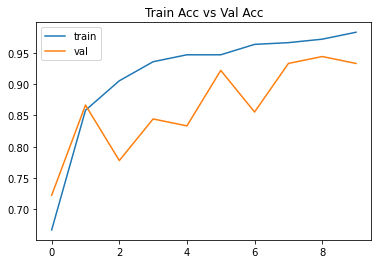

In [60]:
epochs = [i for i in range(10)]
plt.title("Train Acc vs Val Acc")
plt.plot(epochs, train_acc[:10])
plt.plot(epochs, val_acc[:10])
plt.legend(["train", "val"])

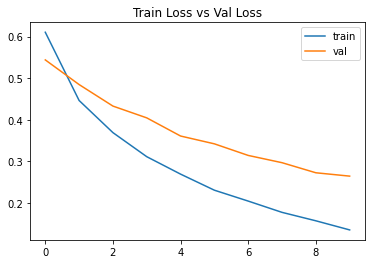

In [61]:
epochs = [i for i in range(10)]
plt.title("Train Loss vs Val Loss")
plt.plot(epochs, train_loss[:10])
plt.plot(epochs, val_loss[:10])
plt.legend(["train", "val"])